In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.metrics import r2_score

from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
numpy.random.seed(7)

In [3]:
dataframe = pandas.read_csv('DataSet_rata-rata(2).csv', usecols=[1], engine='python', skipfooter=0)
dataset = dataframe.values
dataset = dataset.astype('float32')


In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [5]:
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

734 362


In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [7]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [8]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print (numpy.shape(trainX))

(726, 1, 7)


In [9]:
model = Sequential()
#model.add(Embedding(vocab_size, 100, input_length=max_length))
#model.add(Embedding(100, 100))
#model.add(LSTM(20, return_sequences=True, dropout=0.5, recurrent_dropout=0.2, input_shape=(input_length, 1)))
model.add(LSTM(16, input_shape=(1, look_back), return_sequences=True, dropout=0.5, recurrent_dropout=0.2))
#model.add(LSTM(20, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))

#model.add(LSTM(10, activation='relu'))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(1, activation='relu'))

model.add(LSTM(16))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1, activation='tanh'))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())
fit = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=15, batch_size=32, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 16)             1536      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 3,667
Trainable params: 3,667
Non-trainable params: 0
_________________________________________________________________
None
Train on 726 samples, validate on 354 samples
Epoch 1/15
 - 13s - loss: 0.1973 - mean_absolute_error: 0.4298 - mean_squared_error: 0.1973 - val_loss: 0.1488 - val_mean_absolute_error: 0.3716 - val_mean_squared_error: 0.1488
Epoch 2/15
 - 0s - loss: 0.0973 - mean_abso

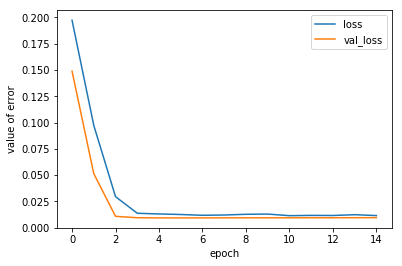

In [10]:
pyplot.plot (fit.history['loss'], label="loss")
pyplot.plot (fit.history['val_loss'], label="val_loss")
#pyplot.plot (fit.history['acc'], label="acc")


#plt.title('LSTM 2 hidden layer semua relu')
plt.xlabel("epoch")
plt.ylabel("value of error")

pyplot.legend()
#pyplot.savefig('2HDFIX_error.png')
pyplot.show()


In [11]:
performansi = model.evaluate(testX, testY, verbose=0)

print (performansi)


[0.009471299944940092, 0.07838133625728262, 0.009471299944940092]


In [12]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])

test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

train_score = math.sqrt(mean_squared_error(trainY[0], train_predict[:,0]))
print('TRAIN SCORE: %.2f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(testY[0], test_predict[:,0]))
print('TEST SCORE:  %.2f RMSE' %(test_score))

TRAIN SCORE: 1.09 RMSE
TEST SCORE:  1.10 RMSE


In [13]:
ravelTestPredict = numpy.ravel(test_predict)
print(numpy.shape(ravelTestPredict))

#print (ravelTestPredict)

raveltestX = numpy.ravel(testY)
print(numpy.shape(raveltestX))

#print (raveltestX)

(354,)
(354,)


In [14]:
train_predict_plot = numpy.empty_like(dataset)
train_predict_plot[:, :] = numpy.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = numpy.empty_like(dataset)
test_predict_plot[:, :] = numpy.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(dataset)-1, :] = test_predict


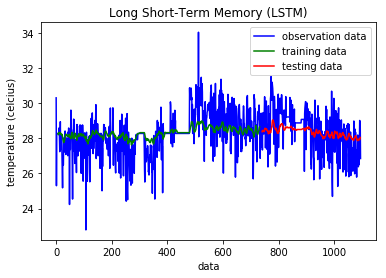

In [15]:
plt.plot(scaler.inverse_transform(dataset),'b', label="observation data")
plt.plot(train_predict_plot,'g', label="training data")
plt.plot(test_predict_plot,'r', label="testing data")
plt.title('Long Short-Term Memory (LSTM)')
plt.xlabel("data")
plt.ylabel("temperature (celcius)")
plt.legend()
#plt.savefig('2HDFIX_plot.png')
plt.show()

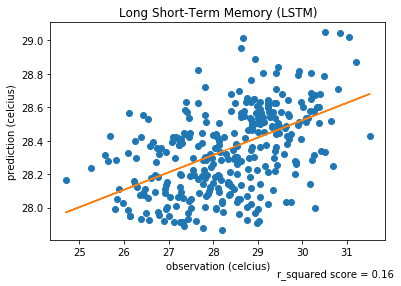

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(raveltestX,ravelTestPredict)
line = slope*raveltestX+intercept
r_squared = r2_score (raveltestX, ravelTestPredict)

fig = plt.figure()
ax = fig.subplots()
ax.plot(raveltestX, ravelTestPredict,'o', raveltestX, line)
ax.set_title('Long Short-Term Memory (LSTM)')
ax.set_xlabel('observation (celcius)')
ax.set_ylabel('prediction (celcius)')
fig.text(.65,-0,'r_squared score = %.2f' % (r_squared))

#plt.legend()

#plt.savefig('2HDFIX_scater-plot.png')

plt.show()
plt.close()